In [1]:
!pip install mxnet

In [23]:
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt 
mx.random.seed(1)

In [3]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [4]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = gluon.data.vision.MNIST(train=True, transform=transform).filter(lambda label: label[-1] in [0,1,2,3,4])
mnist_test = gluon.data.vision.MNIST(train=False, transform=transform).filter(lambda label: label[-1] in [0,1,2,3,4])

In [20]:
image, label = mnist_train[0]

In [6]:
num_inputs = 784
num_outputs = 5
num_examples = len(mnist_train)+len(mnist_test)

In [21]:
im = mx.nd.tile(image, (1,1,3))

In [8]:
batch_size = 128
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)

In [9]:
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

In [10]:
W = nd.random_normal(shape=(num_inputs, num_outputs),ctx=model_ctx)
b = nd.random_normal(shape=num_outputs,ctx=model_ctx)

params = [W, b]

In [11]:
for param in params:
    param.attach_grad()

In [12]:
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear, axis=1).reshape((-1,1)))
    norms = nd.sum(exp, axis=1).reshape((-1,1))
    return exp / norms

In [13]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat

In [14]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat+1e-6))

In [15]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [16]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [17]:
epochs = 5
learning_rate = .005

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 5)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()


    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss: 0.7228378805561101, Train_acc 0.93737745, Test_acc 0.9466822
Epoch 1. Loss: 0.2478171465825902, Train_acc 0.95015687, Test_acc 0.95680094
Epoch 2. Loss: 0.20657477905479332, Train_acc 0.955419, Test_acc 0.96069276
Epoch 3. Loss: 0.1829148658740632, Train_acc 0.95862204, Test_acc 0.96322244
Epoch 4. Loss: 0.1677396100820022, Train_acc 0.9604523, Test_acc 0.96205485


(1, 28, 28, 1)


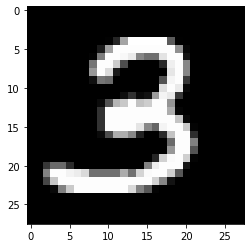

prediction: 
[3.]
<NDArray 1 @cpu(0)>


In [30]:
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# make a prediction
sample_data = mx.gluon.data.DataLoader(mnist_test, 1, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,1*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('prediction:', pred[-1])
    break

In [ ]:
def compute_confusion_matrix(true, pred):
  K = len(np.unique(true)) # Number of classes 
  result = np.zeros((K, K))
  for i in range(len(true)):
    result[true[i]][pred[i]] += 1
  return result